In [14]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

from mutspec.annotation import CodonAnnotation
from mutspec.constants import possible_sbs12, possible_codons, possible_nucls

import pandas as pd
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from Bio.SeqUtils import seq3
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.transforms import TransformedBbox
import numpy as np
from scipy.stats import mannwhitneyu

In [2]:
coda = CodonAnnotation(5)

In [34]:
# _path = "../data/processed/nematoda/22-05-22-15-51-30/mutspec12.tsv"
# edge_mutspec = pd.read_csv(_path, sep='\t')
# ms = edge_mutspec[(edge_mutspec.Label == "syn") & (edge_mutspec.AltNode == "Philometroides_sanguineus")].sort_values("Mut")
# print(ms.shape)
# ms
ms = pd.read_csv("https://raw.githubusercontent.com/VoronkaAlexandr/Sars_Cov_2_MutSpec/main/Sars_Cov_2/new_data/data_obtained/07.Syn_MutSpec_12comp.csv", index_col=0)
ms["MutSpec"] = ms["MutSpec"] / ms["MutSpec"].sum()
ms = ms.rename({"NucSubst": "Mut"}, axis=1)
ms["Mut"] = ms["Mut"].str.replace("U", "T")
ms

,Mut,ExpFr,ObsFr,MutSpec
1,A>C,1590,1564,0.007564
2,A>G,2596,15077,0.044663
3,A>T,1387,3115,0.017271
4,C>A,704,1507,0.016462
5,C>G,582,502,0.006633
6,C>T,1670,73383,0.337923
7,G>A,919,15722,0.131562
8,G>C,277,485,0.013465
9,G>T,277,9508,0.263966
10,T>A,2421,2911,0.009247


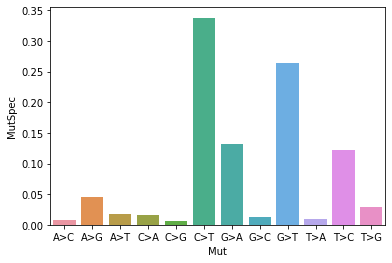

In [35]:
sns.barplot(data=ms, x="Mut", y="MutSpec");

In [36]:
def find_loosers_gainers(df: pd.DataFrame):
    '''
    https://hmmlearn.readthedocs.io/en/latest/tutorial.html

    https://towardsdatascience.com/markov-chain-analysis-and-simulation-using-python-4507cee0b06e

    https://ipython-books.github.io/131-simulating-a-discrete-time-markov-chain/

    #cool?
    https://python.quantecon.org/finite_markov.html

    #code
    https://github.com/vbelz/Markov-chain-simulation
    https://github.com/maximtrp/mchmm

    #drawing
    https://naysan.ca/2020/07/08/drawing-state-transition-diagrams-in-python/
    https://stackoverflow.com/questions/62044102/how-to-visually-animate-markov-chains-in-python

    #online simulator
    http://markov.yoriz.co.uk/
    '''
    assert "Mut" in df.columns
    assert "MutSpec" in df.columns

    sbs_freqs = df.set_index("Mut").MutSpec.to_dict()
    
    
    return

In [37]:
sbs_freqs = ms.set_index("Mut").MutSpec.to_dict()
sbs_freqs

{'A>C': 0.007564461601993488,
 'A>G': 0.04466307752667808,
 'A>T': 0.017271099580795684,
 'C>A': 0.016461863318836336,
 'C>G': 0.006633139497674444,
 'C>T': 0.337922717860373,
 'G>A': 0.13156206417892896,
 'G>C': 0.01346481428803603,
 'G>T': 0.2639658850528797,
 'T>A': 0.00924667970270017,
 'T>C': 0.12284737190723516,
 'T>G': 0.028396825483868834}

In [47]:
sbs_freqs = {'A>C': 0.008663722138708072,
 'A>G': 0.04230534492091637,
 'A>T': 0.017015670193531826,
 'C>A': 0.01758766808652655,
 'C>G': 0.006360957766164506,
 'C>T': 0.3227995997869334,
 'G>A': 0.1937111863538531,
 'G>C': 0.01291230420308119,
 'G>T': 0.253134408995662,
 'T>A': 0.009030539670628595,
 'T>C': 0.08924699697173226,
 'T>G': 0.02723160091226217}

In [48]:
def get_codon_sbs(sbs_freqs):
    codon_sbs_freqs = dict()
    for cdn in possible_codons:
        for i in range(2):
            for nucl in possible_nucls:
                if nucl == cdn[i]:
                    continue
                cdn_alt = nucl + cdn[1:] if i == 0 else cdn[0] + nucl + cdn[-1]
                sbs = cdn[i] + ">" + nucl
                proba = sbs_freqs[sbs]
                codon_sbs_freqs[f"{cdn}>{cdn_alt}"] = proba
    return codon_sbs_freqs


def get_codon_transition_matrix(codon_sbs_freqs: dict):
    n = len(possible_codons)
    matrix = np.zeros((n, n))
    for i, cdn1 in enumerate(possible_codons):
        for j, cdn2 in enumerate(possible_codons):
            csbs = f"{cdn1}>{cdn2}"
            proba = codon_sbs_freqs.get(csbs, 0)
            matrix[i, j] = proba
    matrix = matrix / matrix.sum(axis=1).reshape(-1, 1)
    return matrix

In [49]:
codon_sbs_freqs = get_codon_sbs(sbs_freqs)
tmatrix = get_codon_transition_matrix(codon_sbs_freqs)

In [83]:
codon_sbs_freqs["AGT>ATT"], codon_sbs_freqs["GCC>TCC"]

(0.253134408995662, 0.253134408995662)

In [51]:
tmatrix[0].sum()

1.0000000000000002

In [52]:
tmatrix.min()

0.0

In [79]:
model = hmm.GaussianHMM(n_components=len(possible_codons), covariance_type="full", n_iter=1000, algorithm="map")
# model.startprob_ = np.array(np.ones(len(possible_codons)) / len(possible_codons))
# model.startprob_ = np.random.random(len(possible_codons))
# model.startprob_ = model.startprob_ / model.startprob_.sum()
model.transmat_ = tmatrix


In [80]:
stationar = model.get_stationary_distribution()
stationar_dct = dict(zip(possible_codons, stationar))
print(stationar_dct)

{'AAA': 0.031396180219407786, 'AAC': 6.20126233023418e-17, 'AAG': -7.819900950389424e-17, 'AAT': -5.353176536324064e-17, 'ACA': 0.0505821704744812, 'ACC': 8.77462873475669e-17, 'ACG': -8.892829137373897e-17, 'ACT': -4.7359906363292825e-17, 'AGA': 0.025992227909773357, 'AGC': 4.884432760718744e-17, 'AGG': -5.06859572210754e-17, 'AGT': -2.5962365908954476e-17, 'ATA': 0.08597286788632556, 'ATC': 1.5122581922059565e-16, 'ATG': -1.4864928343740624e-16, 'ATT': -8.283931930739746e-17, 'CAA': 0.050582170474481256, 'CAC': 7.771181836304777e-17, 'CAG': -8.923591213729526e-17, 'CAT': -4.6656229717518725e-17, 'CCA': 0.0446752161006531, 'CCC': 6.604144739749142e-17, 'CCG': -7.004542868827598e-17, 'CCT': -3.80239125010955e-17, 'CGA': 0.02098082233378662, 'CGC': 3.152692974988218e-17, 'CGG': -3.441974297987121e-17, 'CGT': -1.848087192062479e-17, 'CTA': 0.11083232474041818, 'CTC': 1.6506373378963595e-16, 'CTG': -1.745766082590856e-16, 'CTT': -9.499272926641509e-17, 'GAA': 0.025992227909773374, 'GAC': 

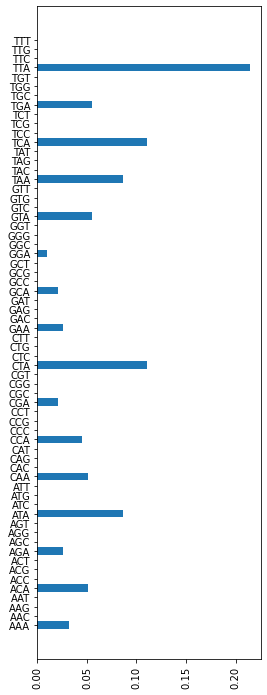

In [81]:
plt.figure(figsize=(4, 12))
plt.barh(possible_codons, stationar)
plt.xticks(rotation=90)
plt.show()

In [56]:
# Leu
prefix = "CT"
for nucl in possible_nucls:
    print(prefix + nucl, ":", stationar_dct[prefix + nucl])

CTA : 0.11083232474041818
CTC : 1.6506373378963595e-16
CTG : -1.745766082590856e-16
CTT : -9.499272926641509e-17


In [175]:
# Ser
prefix = "TC"
for nucl in possible_nucls:
    print(prefix + nucl, ":", stationar_dct[prefix + nucl])

TCA : 0.012017486639084297
TCC : -0.19062072618224596
TCG : -0.6399482967258807
TCT : 0.929383861009464


In [173]:
# Phe + Leu
prefix = "TT"
for nucl in possible_nucls:
    print(prefix + nucl, ":", stationar_dct[prefix + nucl])

TTA : 0.023270490469382864
TTC : -0.3691152672027366
TTG : -1.2391867939694734
TTT : 1.7996457104168244


In [176]:
prefix = "AA"
for nucl in possible_nucls:
    print(prefix + nucl, ":", stationar_dct[prefix + nucl])

AAA : 0.0034042701638609045
AAC : -0.053998350091357394
AAG : -0.18128223965496104
AAT : 0.26327249980186596


In [160]:
# stationar_aa = defaultdict(int)
# for cdn, val in zip(possible_codons, stationar):
#     aa = coda.translate_codon(cdn)
#     stationar_aa[aa] += val

# df = pd.Series(stationar_aa).reset_index(name="n")
# df = df.rename({"index": "aa"}, axis=1).sort_values("n")
# df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from Bio.SeqUtils import seq3
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.transforms import TransformedBbox
import numpy as np
from scipy.stats import mannwhitneyu

pallete_zero=sns.color_palette("vlag", as_cmap=True)

In [ ]:
table_for_heatmap

,codon,aa,start_value_mean,end_value_mean
0,AUG,Met,205.922405,206.873511
1,GAG,Glu,122.958442,121.817372
2,AGC,Ser,39.892993,39.994296
3,CUU,Leu,271.802951,272.106875
4,GUC,Val,109.963361,110.042029
...,...,...,...,...
59,CCG,Pro,16.986549,16.925948
60,CGG,Arg,10.008131,11.000000
61,UAA,Ter,9.127484,9.296207
62,UAG,Ter,1.047782,1.169018


In [ ]:
table_for_heatmap['first_nucl'] = table_for_heatmap['codon'].astype(str).str[0]
table_for_heatmap['second_nucl'] = table_for_heatmap['codon'].astype(str).str[1]
table_for_heatmap['three_nucl'] = table_for_heatmap['codon'].astype(str).str[2]
table_for_heatmap['first_nucl'] = pd.Categorical(table_for_heatmap['first_nucl'],categories=list('CUGA'))
table_for_heatmap['second_nucl'] = pd.Categorical(table_for_heatmap['second_nucl'],categories=list('CUGA'))
table_for_heatmap['three_nucl'] = pd.Categorical(table_for_heatmap['three_nucl'],categories=list('CUGA'))

In [ ]:
table_for_heatmap = table_for_heatmap.sort_values(by=['second_nucl','first_nucl','three_nucl']).reset_index(drop=True)

In [ ]:
table_for_heatmap.head()

,codon,aa,start_value_mean,end_value_mean,first_nucl,second_nucl,three_nucl
0,CCC,Pro,28.980526,28.923747,C,C,C
1,CCU,Pro,190.164626,187.747123,C,C,U
2,CCG,Pro,16.986549,16.925948,C,C,G
3,CCA,Pro,156.921201,154.914540,C,C,A
4,UCC,Ser,50.989058,51.047133,U,C,C


In [ ]:
#table_for_heatmap['prop_codon_start'] = 0.
#table_for_heatmap['prop_codon_in_aa_start'] = 0.
#table_for_heatmap['prop_aa_start'] = 0.

#table_for_heatmap['prop_codon_end'] = 0.
#table_for_heatmap['prop_codon_in_aa_end'] = 0.
#table_for_heatmap['prop_aa_end'] = 0.

#table_for_heatmap['change_prop_codon'] = 0.
#table_for_heatmap['change_prop_codon_in_aa'] = 0.
#table_for_heatmap['change_prop_aa'] = 0.

In [ ]:
table_for_heatmap.loc[table_for_heatmap['codon'].isin(['UCC','UCA','UCG','UCU']), 'aa'] = 'Ser_UC'
table_for_heatmap.loc[table_for_heatmap['codon'].isin(['CUC','CUA','CUG','CUU']), 'aa'] = 'Leu_CU'
table_for_heatmap.loc[table_for_heatmap['codon'].isin(['UUG','UUA']), 'aa'] = 'Leu_UU'
table_for_heatmap.loc[table_for_heatmap['codon'].isin(['CGC','CGA','CGU','CGG']), 'aa'] = 'Arg_CG'
table_for_heatmap.loc[table_for_heatmap['codon'].isin(['UGA']), 'aa'] = '*_UG'
table_for_heatmap.loc[table_for_heatmap['codon'].isin(['AGC','AGU']), 'aa'] = 'Ser_AG'
table_for_heatmap.loc[table_for_heatmap['codon'].isin(['AGG','AGA']), 'aa'] = 'Arg_AG'
table_for_heatmap.loc[table_for_heatmap['codon'].isin(['UAG','UAA']), 'aa'] = '*_UA'

In [ ]:
table_for_heatmap.head()

,codon,aa,start_value_mean,end_value_mean,first_nucl,second_nucl,three_nucl
0,CCC,Pro,28.980526,28.923747,C,C,C
1,CCU,Pro,190.164626,187.747123,C,C,U
2,CCG,Pro,16.986549,16.925948,C,C,G
3,CCA,Pro,156.921201,154.914540,C,C,A
4,UCC,Ser_UC,50.989058,51.047133,U,C,C


In [ ]:
# for index, row in table_for_heatmap.iterrows():
#     table_for_heatmap['prop_codon_start'][index] = table_for_heatmap['start_value_mean'][index] / table_for_heatmap['start_value_mean'].sum()
#     table_for_heatmap['prop_codon_end'][index] = table_for_heatmap['end_value_mean'][index] / table_for_heatmap['end_value_mean'].sum()
    
#     aa = table_for_heatmap['aa'][index]
#     table_for_heatmap['prop_codon_in_aa_start'][index] = table_for_heatmap['start_value_mean'][index] / table_for_heatmap[table_for_heatmap['aa']==aa]['start_value_mean'].sum()
#     table_for_heatmap['prop_codon_in_aa_end'][index] = table_for_heatmap['end_value_mean'][index] / table_for_heatmap[table_for_heatmap['aa']==aa]['end_value_mean'].sum()
    
#     table_for_heatmap['prop_aa_start'][index] = table_for_heatmap[table_for_heatmap['aa']==aa]['start_value_mean'].sum() / table_for_heatmap['start_value_mean'].sum()
#     table_for_heatmap['prop_aa_end'][index] = table_for_heatmap[table_for_heatmap['aa']==aa]['end_value_mean'].sum() / table_for_heatmap['end_value_mean'].sum()
    
# table_for_heatmap['change_prop_codon'] = table_for_heatmap['prop_codon_end'] - table_for_heatmap['prop_codon_start']
# table_for_heatmap['change_prop_codon_in_aa'] = table_for_heatmap['prop_codon_in_aa_end'] - table_for_heatmap['prop_codon_in_aa_start']
# table_for_heatmap['change_prop_aa'] = table_for_heatmap['prop_aa_end'] - table_for_heatmap['prop_aa_start']
table_for_heatmap['aa_start_value'] = 0.
table_for_heatmap['aa_end_value'] = 0.
for index, row in table_for_heatmap.iterrows():
    table_for_heatmap['aa_start_value'][index] = table_for_heatmap.loc[table_for_heatmap['aa'] == table_for_heatmap['aa'][index], 'start_value_mean'].sum()
    table_for_heatmap['aa_end_value'][index] = table_for_heatmap.loc[table_for_heatmap['aa'] == table_for_heatmap['aa'][index], 'end_value_mean'].sum()

C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/2758726446.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['aa_start_value'][index] = table_for_heatmap.loc[table_for_heatmap['aa'] == table_for_heatmap['aa'][index], 'start_value_mean'].sum()
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/2758726446.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['aa_end_value'][index] = table_for_heatmap.loc[table_for_heatmap['aa'] == table_for_heatmap['aa'][index], 'end_value_mean'].sum()


In [ ]:
table_for_heatmap['change_prop_codon'] = table_for_heatmap['end_value_mean'] - table_for_heatmap['start_value_mean']
table_for_heatmap['change_prop_aa'] = table_for_heatmap['aa_end_value'] - table_for_heatmap['aa_start_value']

In [ ]:
c_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'C']['change_prop_codon'])
u_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'U']['change_prop_codon'])
g_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'G']['change_prop_codon'])
a_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'A']['change_prop_codon'])
df_heatmap_codon_change_value = pd.DataFrame({'C':c_value, 'U':u_value, 'G':g_value, 'A':a_value})
#data_values = np.array([c_value,u_value,g_value,a_value])
name_df = table_for_heatmap[['codon', 'aa', 'change_prop_codon', 'second_nucl']]

In [ ]:
name_df.head()

,codon,aa,change_prop_codon,second_nucl
0,CCC,Pro,-0.056779,C
1,CCU,Pro,-2.417503,C
2,CCG,Pro,-0.060601,C
3,CCA,Pro,-2.006660,C
4,UCC,Ser_UC,0.058075,C


In [ ]:
name_df.loc[name_df.duplicated('aa'), 'aa'] = ''
name_df[name_df['codon'] == 'AUA']['aa'] = 'Ile'
name_df['change_prop_codon'] = round(name_df['change_prop_codon'],4).astype('str')
name_df['summ_info'] = name_df['codon'] + ' ' + name_df['change_prop_codon']

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/2963528697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_df[name_df['codon'] == 'AUA']['aa'] = 'Ile'
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/2963528697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [ ]:
name_df['summ_info'] = name_df['codon'] + ' ' + name_df['change_prop_codon']

C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/3071744796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_df['summ_info'] = name_df['codon'] + ' ' + name_df['change_prop_codon']


In [ ]:
c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
u_name = list(name_df[name_df['second_nucl'] == 'U']['summ_info'])
g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
df_heatmap_codon_change_name = pd.DataFrame({'C':c_name, 'U':u_name, 'G':g_name, 'A':a_name})
c_aa = list(name_df[name_df['second_nucl'] == 'C']['aa'])
u_aa = list(name_df[name_df['second_nucl'] == 'U']['aa'])
g_aa = list(name_df[name_df['second_nucl'] == 'G']['aa'])
a_aa = list(name_df[name_df['second_nucl'] == 'A']['aa'])
df_heatmap_codon_change_aa = pd.DataFrame({'C':c_aa, 'U':u_aa, 'G':g_aa, 'A':a_aa})

In [ ]:
df_heatmap_codon_change_value

,C,U,G,A
0,-0.056779,-0.001914,-0.051782,0.108434
1,-2.417503,0.303924,0.945140,-0.178850
2,-0.060601,-0.988128,0.991869,0.342455
3,-2.006660,1.966199,-0.147839,-0.189542
4,0.058075,-2.445847,0.134203,-0.053166
5,1.972770,0.647849,0.868532,1.003163
6,0.053591,0.139404,0.079611,0.121237
7,-1.076051,2.109045,0.178511,0.168723
8,-0.125155,0.078669,0.793816,-2.052432
9,-0.679931,0.388275,-2.382303,-1.724857


In [ ]:
def draw_heat_map(df_heatmap_codon_change_value, df_heatmap_codon_change_name,
                  df_heatmap_codon_change_aa, file_name,
                  cmd=sns.palettes.blend_palette(('#ffffff10', '#ff0000af'), 6, as_cmap=True),
                  title='Heatmap', minmax=5.2):
    fig, ax = plt.subplots(figsize=(18, 18))
    if cmd == pallete_zero:
        sns.heatmap(df_heatmap_codon_change_value, fmt='', cmap=cmd, vmin=-minmax, vmax=minmax)
    else:
        sns.heatmap(df_heatmap_codon_change_value, fmt='', cmap=cmd)
    #annot=df_heatmap_codon_change_name, annot_kws={"ha":'left',"size":20}
    for y in range(df_heatmap_codon_change_aa.shape[0]):
        for x in range(df_heatmap_codon_change_aa.shape[1]):
            plt.text(x+0.03, y+0.07, df_heatmap_codon_change_aa.iloc[y, x],
                     horizontalalignment='left', verticalalignment='top', color='black', fontsize=30)
            plt.text(x+0.03, y+0.6, df_heatmap_codon_change_name.iloc[y, x],
                     horizontalalignment='left', verticalalignment='top', color='black', fontsize=20)

    ax.set_yticks(np.arange(0, 16, 1))
    ax.set_ylabel('First Nucleotide', size=40)
    ax.set_xlabel('Second Nucleotide', size=40)
    ax.set_title(title, size=20)
    ax.set_yticklabels(('', '', 'C', '', '', '', 'U', '', '', '', 'G', '', '', '', 'A', ''),
                       rotation=0, fontsize="40", va="center")
    plt.xticks(fontsize=40)
    ax.add_patch(patches.Rectangle((0, 0), 1.0, 4.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((0, 4), 1.0, 4.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((0, 8), 1.0, 4.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((0, 12), 1.0, 4.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((1, 0), 1.0, 4.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((1, 4), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((1, 6), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((1, 8), 1.0, 4.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((1, 12), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((1, 14), 1.0, 1.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((1, 15), 1.0, 1.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((2, 0), 1.0, 4.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((2, 4), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((2, 6), 1.0, 1.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((2, 7), 1.0, 1.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((2, 8), 1.0, 4.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((2, 12), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((2, 14), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((3, 0), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((3, 2), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((3, 4), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((3, 6), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((3, 8), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((3, 10), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((3, 12), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    ax.add_patch(patches.Rectangle((3, 14), 1.0, 2.0, edgecolor='black', fill=False, lw=4))
    plt.show()
    # fig.savefig(f'{file_name}.pdf', dpi=300)

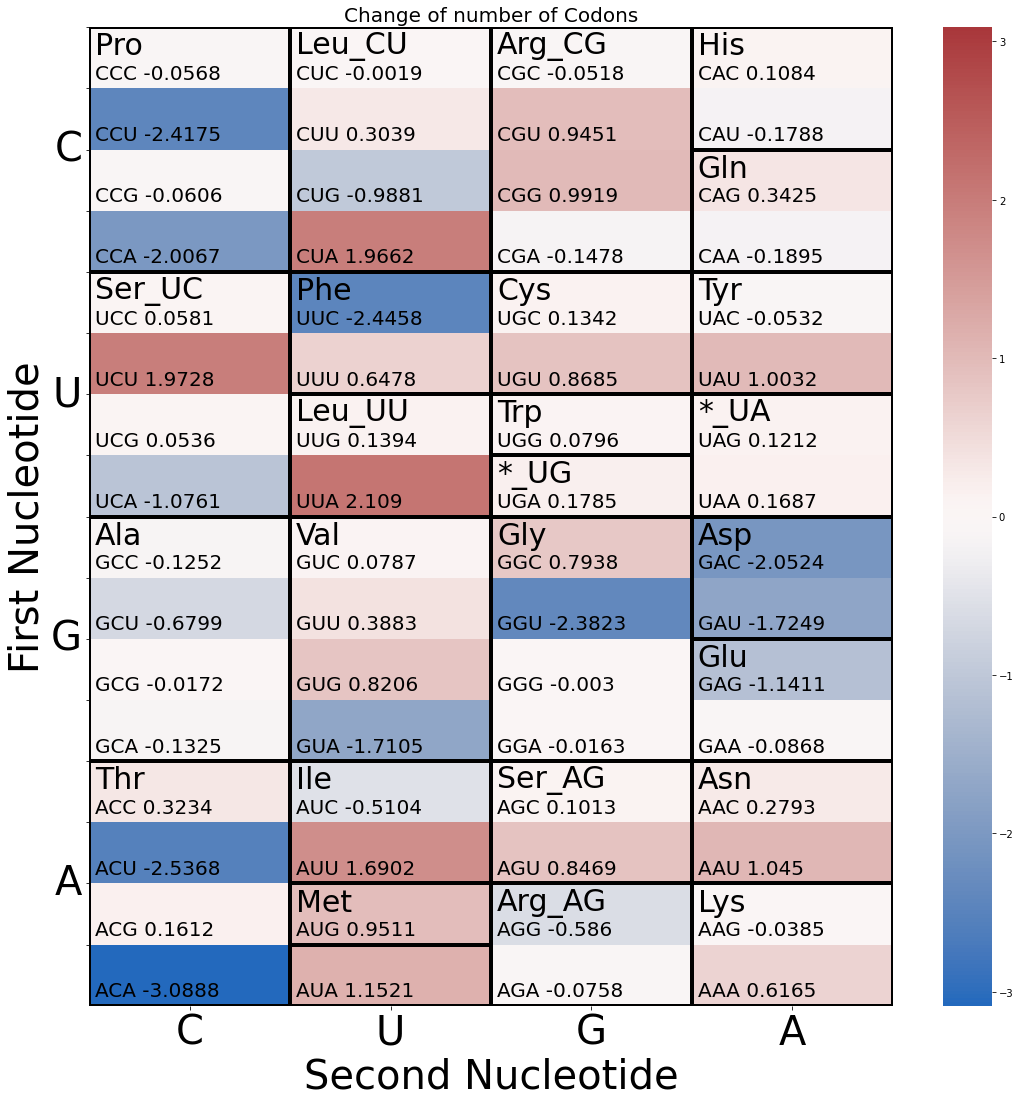

In [ ]:
draw_heat_map(df_heatmap_codon_change_value, df_heatmap_codon_change_name, 
              df_heatmap_codon_change_aa, 'Change_number_codons', cmd=pallete_zero, title='Change of number of Codons',
              minmax=max(abs(df_heatmap_codon_change_value.min().min()), df_heatmap_codon_change_value.max().max()))

In [ ]:
# c_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'C']['change_prop_codon_in_aa'])
# u_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'U']['change_prop_codon_in_aa'])
# g_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'G']['change_prop_codon_in_aa'])
# a_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'A']['change_prop_codon_in_aa'])
# df_heatmap_codon_change_value = pd.DataFrame({'C':c_value, 'U':u_value, 'G':g_value, 'A':a_value})
# #data_values = np.array([c_value,u_value,g_value,a_value])
# name_df = table_for_heatmap[['codon', 'aa', 'change_prop_codon_in_aa', 'second_nucl']]
# name_df.loc[name_df.duplicated('aa'), 'aa'] = ''
# name_df[name_df['codon'] == 'AUA']['aa'] = 'I'
# name_df['change_prop_codon_in_aa'] = round(name_df['change_prop_codon_in_aa'],4).astype('str')
# name_df['summ_info'] = name_df['codon'] + ' ' + name_df['change_prop_codon_in_aa']
# c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
# u_name = list(name_df[name_df['second_nucl'] == 'U']['summ_info'])
# g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
# a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
# df_heatmap_codon_change_name = pd.DataFrame({'C':c_name, 'U':u_name, 'G':g_name, 'A':a_name})
# c_aa = list(name_df[name_df['second_nucl'] == 'C']['aa'])
# u_aa = list(name_df[name_df['second_nucl'] == 'U']['aa'])
# g_aa = list(name_df[name_df['second_nucl'] == 'G']['aa'])
# a_aa = list(name_df[name_df['second_nucl'] == 'A']['aa'])
# df_heatmap_codon_change_aa = pd.DataFrame({'C':c_aa, 'U':u_aa, 'G':g_aa, 'A':a_aa})

In [ ]:
# draw_heat_map(df_heatmap_codon_change_value, df_heatmap_codon_change_name, df_heatmap_codon_change_aa, 'Change_number_codons', cmd=sns.color_palette("vlag", as_cmap=True))

In [ ]:
name_df

,codon,aa,change_prop_codon,second_nucl,summ_info
0,CCC,Pro,-0.0568,C,CCC -0.0568
1,CCU,,-2.4175,C,CCU -2.4175
2,CCG,,-0.0606,C,CCG -0.0606
3,CCA,,-2.0067,C,CCA -2.0067
4,UCC,Ser_UC,0.0581,C,UCC 0.0581
...,...,...,...,...,...
59,GAA,,-0.0868,A,GAA -0.0868
60,AAC,Asn,0.2793,A,AAC 0.2793
61,AAU,,1.045,A,AAU 1.045
62,AAG,Lys,-0.0385,A,AAG -0.0385


In [ ]:
c_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'C']['change_prop_aa'])
u_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'U']['change_prop_aa'])
g_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'G']['change_prop_aa'])
a_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'A']['change_prop_aa'])
df_heatmap_codon_change_value = pd.DataFrame({'C':c_value, 'U':u_value, 'G':g_value, 'A':a_value})
#data_values = np.array([c_value,u_value,g_value,a_value])
name_df = table_for_heatmap[['codon', 'aa', 'change_prop_aa', 'second_nucl']]
name_df['change_prop_aa'] = round(name_df['change_prop_aa'],2).astype('str')
name_df.loc[name_df.duplicated('aa'), ['aa','change_prop_aa']] = ''
name_df[name_df['codon'] == 'AUA']['aa'] = 'Ile'
name_df['summ_info'] = name_df['codon'] #+ ' ' + name_df['change_prop_aa']
c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
u_name = list(name_df[name_df['second_nucl'] == 'U']['summ_info'])
g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
df_heatmap_codon_change_name = pd.DataFrame({'C':c_name, 'U':u_name, 'G':g_name, 'A':a_name})

name_df.loc[name_df['aa'] == 'Ser_UC','aa'] = 'Ser'
name_df.loc[name_df['aa'] == 'Leu_CU','aa'] = 'Leu'
name_df.loc[name_df['aa'] == 'Leu_UU','aa'] = 'Leu'
name_df.loc[name_df['aa'] == 'Arg_CG','aa'] = 'Arg'
name_df.loc[name_df['aa'] == '*_UG','aa'] = '*'
name_df.loc[name_df['aa'] == 'Ser_AG','aa'] = 'Ser'
name_df.loc[name_df['aa'] == 'Arg_AG','aa'] = 'Arg'
name_df.loc[name_df['aa'] == '*_UA','aa'] = '*'

name_df['aa'] = name_df['aa'] + ' ' + name_df['change_prop_aa']
c_aa = list(name_df[name_df['second_nucl'] == 'C']['aa'])
u_aa = list(name_df[name_df['second_nucl'] == 'U']['aa'])
g_aa = list(name_df[name_df['second_nucl'] == 'G']['aa'])
a_aa = list(name_df[name_df['second_nucl'] == 'A']['aa'])
#c_aa[4] = 'Ser'
#u_aa[0] = 'Leu'
#u_aa[6] = 'Leu'
#g_aa[0] = 'Arg'
#g_aa[7] = '*'
#g_aa[12] = 'Ser'
#g_aa[14] = 'Arg'
#a_aa[6] = '*'
df_heatmap_codon_change_aa = pd.DataFrame({'C':c_aa, 'U':u_aa, 'G':g_aa, 'A':a_aa})

C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/3453735741.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_df['change_prop_aa'] = round(name_df['change_prop_aa'],2).astype('str')
c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/3453735741.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

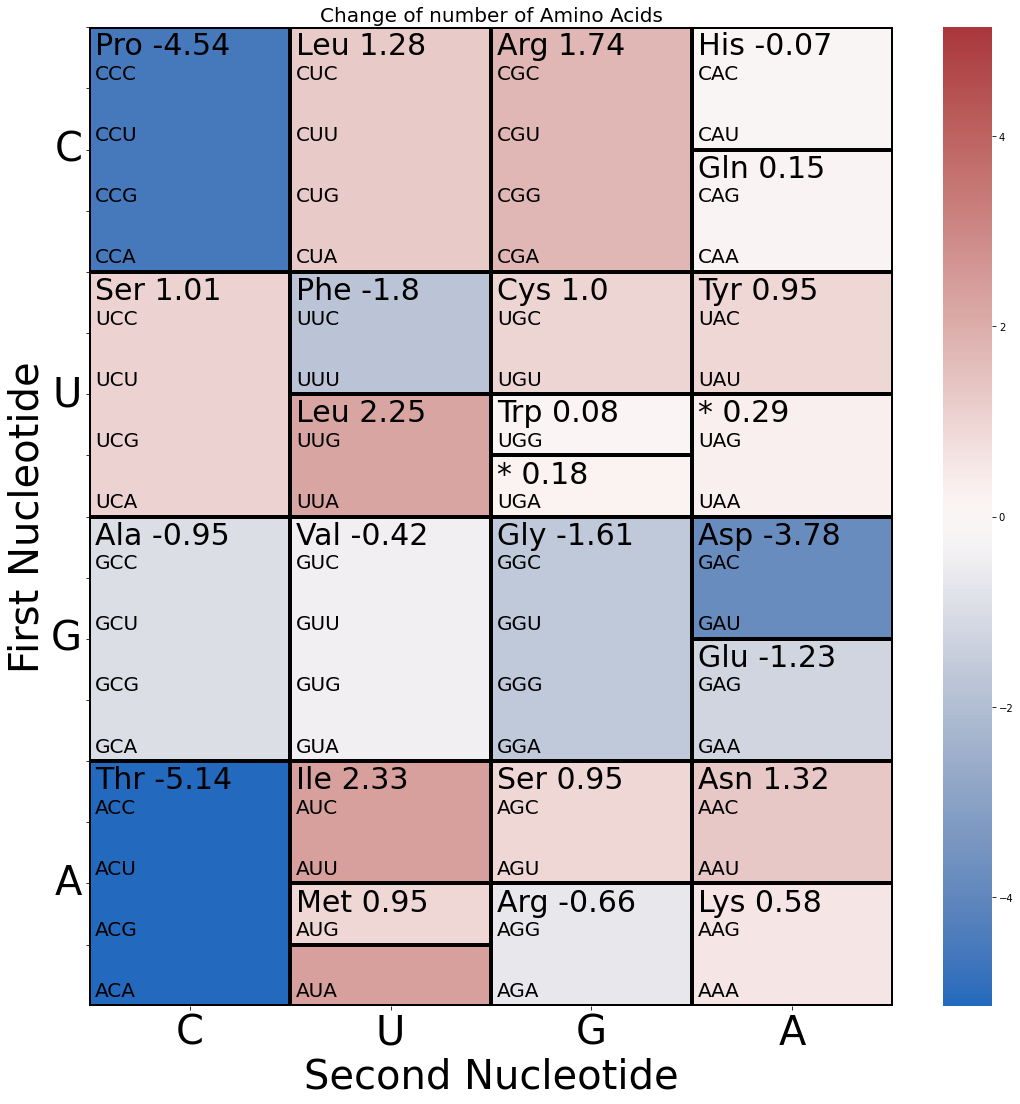

In [ ]:
draw_heat_map(df_heatmap_codon_change_value, df_heatmap_codon_change_name, 
              df_heatmap_codon_change_aa, 'Change_number_aa', cmd=pallete_zero, title='Change of number of Amino Acids',
              minmax=max(abs(df_heatmap_codon_change_value.min().min()), df_heatmap_codon_change_value.max().max()))

In [ ]:
df = pd.read_csv('../U_ideal_table.csv', index_col=0)

In [ ]:
df = df[df['GenType']=='translated']

In [ ]:
df = df[['Pos', 'RefAa', 'RefCodon']].drop_duplicates().reset_index(drop=True)

In [ ]:
ref_df = df.groupby(['RefAa', 'RefCodon']).count().reset_index()

In [ ]:
ref_df['Pos'] = ref_df['Pos']/3

In [ ]:
df_app = pd.DataFrame({'RefAa':'*_UG', 'RefCodon':'UGA', 'Pos':0}, index = [0])
ref_df = ref_df.append(df_app, ignore_index=True)

In [ ]:
ref_df['first_nucl'] = ref_df['RefCodon'].astype(str).str[0]
ref_df['second_nucl'] = ref_df['RefCodon'].astype(str).str[1]
ref_df['three_nucl'] = ref_df['RefCodon'].astype(str).str[2]
ref_df['first_nucl'] = pd.Categorical(ref_df['first_nucl'],categories=list('CUGA'))
ref_df['second_nucl'] = pd.Categorical(ref_df['second_nucl'],categories=list('CUGA'))
ref_df['three_nucl'] = pd.Categorical(ref_df['three_nucl'],categories=list('CUGA'))

In [ ]:
ref_df = ref_df.sort_values(by=['second_nucl','first_nucl','three_nucl']).reset_index(drop=True)

In [ ]:
ref_df['Pos'] = round(ref_df['Pos'])

In [ ]:
c_value = list(ref_df[ref_df['second_nucl'] == 'C']['Pos'].astype('int'))
u_value = list(ref_df[ref_df['second_nucl'] == 'U']['Pos'].astype('int'))
g_value = list(ref_df[ref_df['second_nucl'] == 'G']['Pos'].astype('int'))
a_value = list(ref_df[ref_df['second_nucl'] == 'A']['Pos'].astype('int'))
df_heatmap_codon_change_value = pd.DataFrame({'C':c_value, 'U':u_value, 'G':g_value, 'A':a_value})
#data_values = np.array([c_value,u_value,g_value,a_value])
name_df = ref_df[['RefCodon', 'RefAa', 'Pos', 'second_nucl']]

In [ ]:
name_df.loc[name_df.duplicated('RefAa'), 'RefAa'] = ''
name_df[name_df['RefCodon'] == 'AUA']['RefAa'] = 'Ile'
name_df['Pos'] = name_df['Pos'].astype('float').astype('int')
name_df['summ_info'] = name_df['RefCodon'] + ' ' + name_df['Pos'].astype('str')

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/3788588554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_df[name_df['RefCodon'] == 'AUA']['RefAa'] = 'Ile'
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/3788588554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [ ]:
c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
u_name = list(name_df[name_df['second_nucl'] == 'U']['summ_info'])
g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
df_heatmap_codon_change_name = pd.DataFrame({'C':c_name, 'U':u_name, 'G':g_name, 'A':a_name})
c_aa = list(name_df[name_df['second_nucl'] == 'C']['RefAa'])
u_aa = list(name_df[name_df['second_nucl'] == 'U']['RefAa'])
g_aa = list(name_df[name_df['second_nucl'] == 'G']['RefAa'])
a_aa = list(name_df[name_df['second_nucl'] == 'A']['RefAa'])
c_aa[4] = 'Ser'
u_aa[0] = 'Leu'
u_aa[6] = 'Leu'
g_aa[0] = 'Arg'
g_aa[7] = '*'
g_aa[12] = 'Ser'
g_aa[14] = 'Arg'
a_aa[6] = '*'
df_heatmap_codon_change_aa = pd.DataFrame({'C':c_aa, 'U':u_aa, 'G':g_aa, 'A':a_aa})

In [ ]:
xxc = np.append(df_heatmap_codon_change_value.iloc[[0],].values, [df_heatmap_codon_change_value.iloc[[4],].values, 
                df_heatmap_codon_change_value.iloc[[8],].values, df_heatmap_codon_change_value.iloc[[12],].values])
xxu = np.append(df_heatmap_codon_change_value.iloc[[1],].values, [df_heatmap_codon_change_value.iloc[[5],].values, 
                df_heatmap_codon_change_value.iloc[[9],].values, df_heatmap_codon_change_value.iloc[[13],].values])
xxg = np.append(df_heatmap_codon_change_value.iloc[[2],].values, [df_heatmap_codon_change_value.iloc[[6],].values, 
                df_heatmap_codon_change_value.iloc[[10],].values, df_heatmap_codon_change_value.iloc[[14],].values])
xxa = np.append(df_heatmap_codon_change_value.iloc[[3],].values, [df_heatmap_codon_change_value.iloc[[7],].values, 
                df_heatmap_codon_change_value.iloc[[11],].values, df_heatmap_codon_change_value.iloc[[15],].values])

In [ ]:
trinuc = [xxc, xxu, xxg, xxa]
trinucnames = ['xxc', 'xxu', 'xxg', 'xxa']
man_dict = {}
for i, i_name in zip(trinuc, trinucnames):
    for x, x_name in zip(trinuc, trinucnames):
        if i_name!=x_name:
            s, p = mannwhitneyu(i, x)
            man_dict[i_name+'_'+x_name] = p 
man_df = pd.DataFrame(man_dict, index=[0]).transpose().reset_index()
man_df.columns = ['codon_lins_compared', 'p_value']
man_df.to_csv('Manna_Whitney_RefCodonUsage.csv')

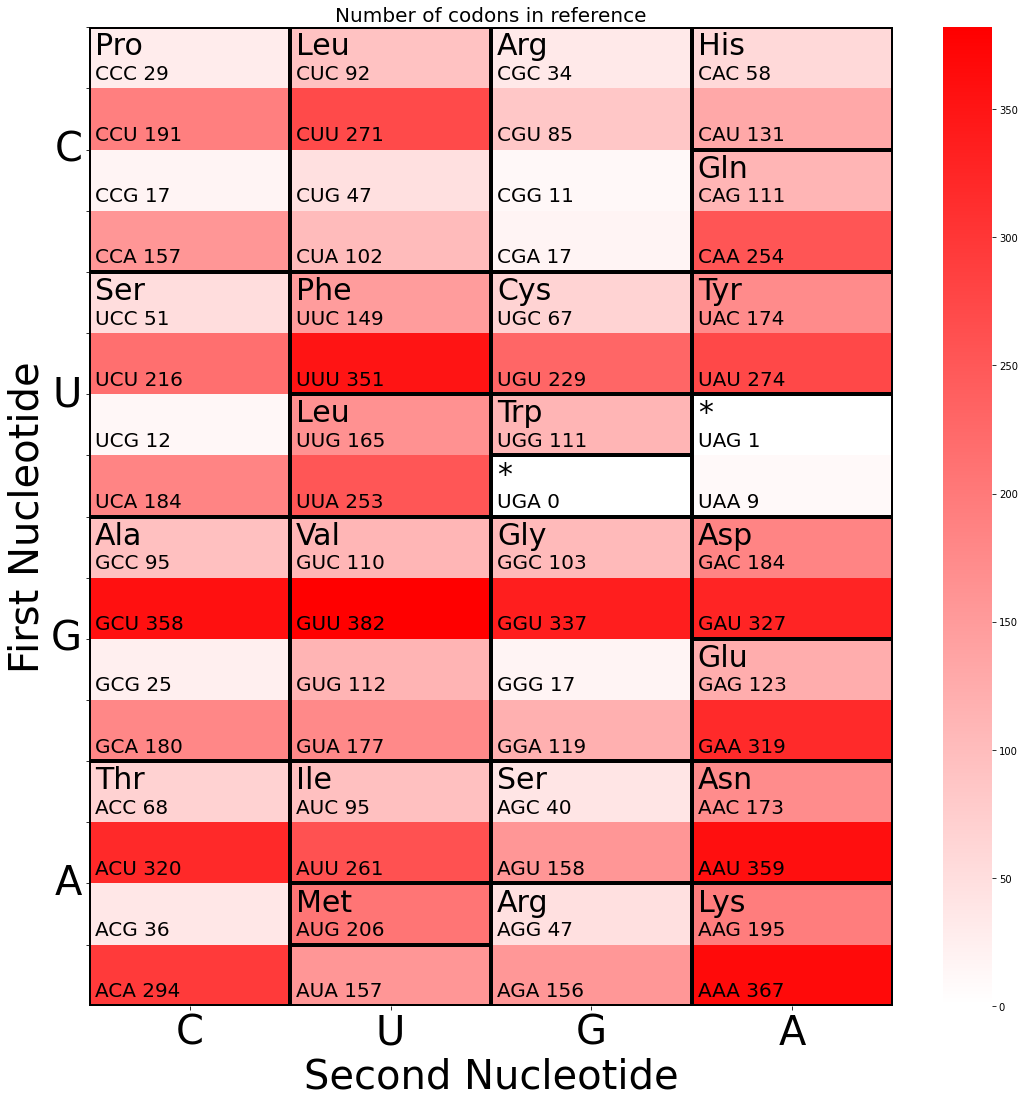

In [ ]:
draw_heat_map(df_heatmap_codon_change_value, df_heatmap_codon_change_name, 
              df_heatmap_codon_change_aa, 'Codons_ref_seq', title='Number of codons in reference')

In [ ]:
ref_df['codon_in_aa'] = 0.
for index, row in ref_df.iterrows():
    if ref_df[ref_df['RefAa'] == ref_df['RefAa'][index]]['Pos'].sum() != 0:
        ref_df['codon_in_aa'][index] = (ref_df['Pos'][index]) / (ref_df[ref_df['RefAa'] == ref_df['RefAa'][index]]['Pos'].sum())

C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/263887028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['codon_in_aa'][index] = (ref_df['Pos'][index]) / (ref_df[ref_df['RefAa'] == ref_df['RefAa'][index]]['Pos'].sum())


In [ ]:
c_value = list(ref_df[ref_df['second_nucl'] == 'C']['codon_in_aa'])
u_value = list(ref_df[ref_df['second_nucl'] == 'U']['codon_in_aa'])
g_value = list(ref_df[ref_df['second_nucl'] == 'G']['codon_in_aa'])
a_value = list(ref_df[ref_df['second_nucl'] == 'A']['codon_in_aa'])
df_heatmap_codon_change_value = pd.DataFrame({'C':c_value, 'U':u_value, 'G':g_value, 'A':a_value})
#data_values = np.array([c_value,u_value,g_value,a_value])
name_df = ref_df[['RefCodon', 'RefAa', 'codon_in_aa', 'second_nucl']]

name_df.loc[name_df.duplicated('RefAa'), 'RefAa'] = ''
name_df[name_df['RefCodon'] == 'AUA']['RefAa'] = 'Ile'
name_df['codon_in_aa'] = round(name_df['codon_in_aa'],4).astype('str')
name_df['summ_info'] = name_df['RefCodon'] + ' ' + name_df['codon_in_aa']

c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
u_name = list(name_df[name_df['second_nucl'] == 'U']['summ_info'])
g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
df_heatmap_codon_change_name = pd.DataFrame({'C':c_name, 'U':u_name, 'G':g_name, 'A':a_name})
c_aa = list(name_df[name_df['second_nucl'] == 'C']['RefAa'])
u_aa = list(name_df[name_df['second_nucl'] == 'U']['RefAa'])
g_aa = list(name_df[name_df['second_nucl'] == 'G']['RefAa'])
a_aa = list(name_df[name_df['second_nucl'] == 'A']['RefAa'])
df_heatmap_codon_change_aa = pd.DataFrame({'C':c_aa, 'U':u_aa, 'G':g_aa, 'A':a_aa})

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/1404308939.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_df[name_df['RefCodon'] == 'AUA']['RefAa'] = 'Ile'
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/1404308939.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

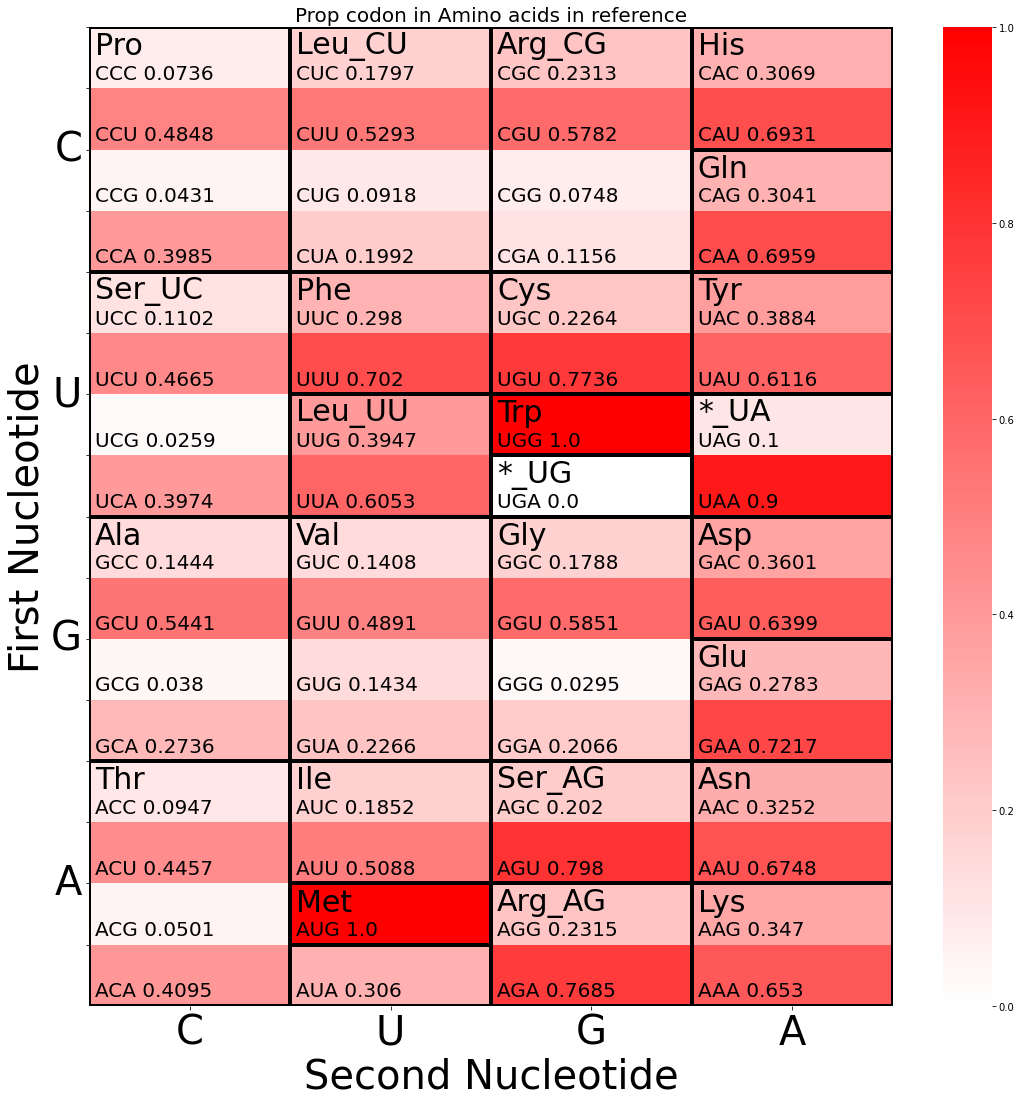

In [ ]:
draw_heat_map(df_heatmap_codon_change_value, df_heatmap_codon_change_name, 
              df_heatmap_codon_change_aa, 'Codons_in_aa', title='Prop codon in Amino acids in reference')

In [ ]:
ref_df['aa_count'] = 0
for index, row in ref_df.iterrows():
    ref_df['aa_count'][index] = ref_df.loc[ref_df['RefAa'] == ref_df['RefAa'][index], 'Pos'].sum()

C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/919180911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['aa_count'][index] = ref_df.loc[ref_df['RefAa'] == ref_df['RefAa'][index], 'Pos'].sum()


In [ ]:
c_value = list(ref_df[ref_df['second_nucl'] == 'C']['aa_count'])
u_value = list(ref_df[ref_df['second_nucl'] == 'U']['aa_count'])
g_value = list(ref_df[ref_df['second_nucl'] == 'G']['aa_count'])
a_value = list(ref_df[ref_df['second_nucl'] == 'A']['aa_count'])
df_heatmap_codon_change_value = pd.DataFrame({'C':c_value, 'U':u_value, 'G':g_value, 'A':a_value})
#data_values = np.array([c_value,u_value,g_value,a_value])
name_df = ref_df[['RefCodon', 'RefAa', 'aa_count', 'second_nucl']]
name_df['aa_count'] = round(name_df['aa_count'],4).astype('str')
name_df.loc[name_df.duplicated('RefAa'), ['RefAa','aa_count']] = ''
name_df[name_df['RefCodon'] == 'AUA']['RefAa'] = 'Ile'
name_df['summ_info'] = name_df['RefCodon'] + ' ' + name_df['aa_count']
c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
u_name = list(name_df[name_df['second_nucl'] == 'U']['summ_info'])
g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
df_heatmap_codon_change_name = pd.DataFrame({'C':c_name, 'U':u_name, 'G':g_name, 'A':a_name})
c_aa = list(name_df[name_df['second_nucl'] == 'C']['RefAa'])
u_aa = list(name_df[name_df['second_nucl'] == 'U']['RefAa'])
g_aa = list(name_df[name_df['second_nucl'] == 'G']['RefAa'])
a_aa = list(name_df[name_df['second_nucl'] == 'A']['RefAa'])
df_heatmap_codon_change_aa = pd.DataFrame({'C':c_aa, 'U':u_aa, 'G':g_aa, 'A':a_aa})

C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/4235202012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_df['aa_count'] = round(name_df['aa_count'],4).astype('str')
c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_13916/4235202012.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

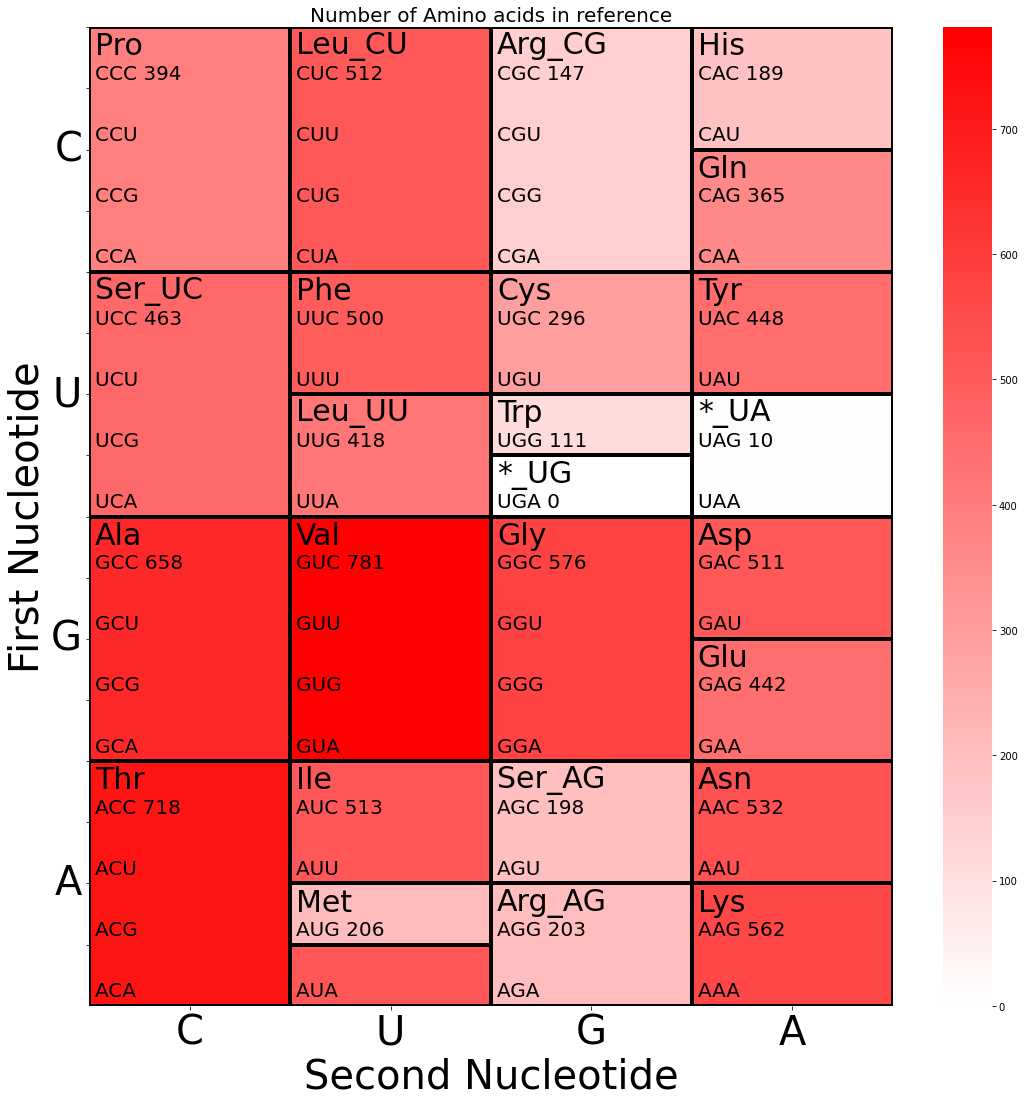

In [ ]:
draw_heat_map(df_heatmap_codon_change_value, df_heatmap_codon_change_name, 
              df_heatmap_codon_change_aa, 'aa_count', title='Number of Amino acids in reference')

In [ ]:
#for Alya
df = pd.read_csv('Alya/Body/3Results/AllGenesCodonUsageNoOverlap.txt', sep='\t', )
#with open('Alya/Body/3Results/AllGenesCodonUsageNoOverlap.txt') as f:
#    print(f.readline())
#    print(f.readline())

In [ ]:
codons_t = []
nuc_one = ['A', 'T', 'G', 'C']
nuc_two = ['A', 'T', 'G', 'C']
nuc_three = ['A', 'T', 'G', 'C']
for first in nuc_one:
    for second in nuc_two:
        for three in nuc_three:
            codons_t.append(first+second+three)

In [ ]:
# Tarsipes_rostratus or Balaena_mysticetus
organism = 'Tarsipes_rostratus'
name = organism
df_tar_ros = df[df['Species'] == organism][codons_t].reset_index(drop=True)

In [ ]:
table_for_heatmap = pd.DataFrame(columns=['codon', 'aa', 'codon_count'])

In [ ]:
index_num = 0
for codon in df_tar_ros.columns:
    codon_name = codon
    aa_name = seq3(Seq(codon).translate()[0])
    value = df_tar_ros[codon].sum()
    data = {'codon':codon_name, 'aa':aa_name, 'codon_count':value}
    df = pd.DataFrame(data, index=[index_num])
    table_for_heatmap = table_for_heatmap.append(df)
    index_num+=1

In [ ]:
table_for_heatmap.loc[table_for_heatmap['codon'] == 'ATA','aa'] = 'Met'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'TGA','aa'] = 'Trp'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'AGA','aa'] = '*'
table_for_heatmap.loc[table_for_heatmap['codon'] == 'AGG','aa'] = '*'

In [ ]:
table_for_heatmap['first_nucl'] = table_for_heatmap['codon'].astype(str).str[0]
table_for_heatmap['second_nucl'] = table_for_heatmap['codon'].astype(str).str[1]
table_for_heatmap['three_nucl'] = table_for_heatmap['codon'].astype(str).str[2]
table_for_heatmap['first_nucl'] = pd.Categorical(table_for_heatmap['first_nucl'],categories=list('TCAG'))
table_for_heatmap['second_nucl'] = pd.Categorical(table_for_heatmap['second_nucl'],categories=list('TCAG'))
table_for_heatmap['three_nucl'] = pd.Categorical(table_for_heatmap['three_nucl'],categories=list('TCAG'))

In [ ]:
table_for_heatmap = table_for_heatmap.sort_values(by=['second_nucl','first_nucl','three_nucl']).reset_index(drop=True)

In [ ]:
table_for_heatmap['for_count'] = 0
for i in range(0,len(table_for_heatmap),2):
    table_for_heatmap['for_count'][i] = i
    table_for_heatmap['for_count'][i+1] = i

C:\Users\ASUS\AppData\Local\Temp/ipykernel_14072/383273933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['for_count'][i] = i
C:\Users\ASUS\AppData\Local\Temp/ipykernel_14072/383273933.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['for_count'][i+1] = i


In [ ]:
table_for_heatmap['codon_prop'] = 0.
for index, row in table_for_heatmap.iterrows():
    if table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum() != 0:
        table_for_heatmap['codon_prop'][index] = table_for_heatmap['codon_count'][index] / table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum()

C:\Users\ASUS\AppData\Local\Temp/ipykernel_14072/459003438.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['codon_prop'][index] = table_for_heatmap['codon_count'][index] / table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum()
C:\Users\ASUS\AppData\Local\Temp/ipykernel_14072/459003438.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_for_heatmap['codon_prop'][index] = table_for_heatmap['codon_count'][index] / table_for_heatmap[table_for_heatmap['for_count'] == table_for_heatmap['for_count'][index]]['codon_count'].sum()
C:\Users\ASUS\

In [ ]:
table_for_heatmap.head()

,codon,aa,codon_count,first_nucl,second_nucl,three_nucl,for_count,codon_prop
0,TTT,Phe,97,T,T,T,0,0.431111
1,TTC,Phe,128,T,T,C,0,0.568889
2,TTA,Leu,154,T,T,A,2,0.900585
3,TTG,Leu,17,T,T,G,2,0.099415
4,CTT,Leu,107,C,T,T,4,0.548718


In [ ]:
c_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'C']['codon_prop'])
u_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'T']['codon_prop'])
g_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'G']['codon_prop'])
a_value = list(table_for_heatmap[table_for_heatmap['second_nucl'] == 'A']['codon_prop'])
df_heatmap_codon_change_value = pd.DataFrame({'T':u_value, 'C':c_value, 'A':a_value, 'G':g_value})
#data_values = np.array([c_value,u_value,g_value,a_value])
name_df = table_for_heatmap[['codon', 'aa', 'codon_prop', 'second_nucl']]

name_df.loc[name_df.duplicated('aa'), 'aa'] = ''
name_df.loc[name_df['codon'] == 'CTT','aa'] = 'Leu'
name_df.loc[name_df['codon'] == 'AGT','aa'] = 'Ser'
name_df.loc[name_df['codon'] == 'AGA','aa'] = '*'
name_df.loc[name_df['codon'] == 'TAA','aa'] = '*'

name_df['codon_prop'] = round(name_df['codon_prop'],4).astype('str')
name_df['summ_info'] = name_df['codon'] + ' ' + name_df['codon_prop']

c_name = list(name_df[name_df['second_nucl'] == 'C']['summ_info'])
u_name = list(name_df[name_df['second_nucl'] == 'T']['summ_info'])
g_name = list(name_df[name_df['second_nucl'] == 'G']['summ_info'])
a_name = list(name_df[name_df['second_nucl'] == 'A']['summ_info'])
df_heatmap_codon_change_name = pd.DataFrame({'T':u_name, 'C':c_name, 'A':a_name, 'G':g_name})
c_aa = list(name_df[name_df['second_nucl'] == 'C']['aa'])
u_aa = list(name_df[name_df['second_nucl'] == 'T']['aa'])
g_aa = list(name_df[name_df['second_nucl'] == 'G']['aa'])
a_aa = list(name_df[name_df['second_nucl'] == 'A']['aa'])
df_heatmap_codon_change_aa = pd.DataFrame({'T':u_aa, 'C':c_aa, 'A':a_aa, 'G':g_aa})

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_14072/1118555377.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  name_df['codon_prop'] = round(name_df['codon_prop'],4).astype('str')
C:\Users\ASUS\AppData\Local\Temp/ipykernel_14072/1118555377.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [ ]:
def draw_heat_map_mito(df_heatmap_codon_change_value, df_heatmap_codon_change_name,
                  df_heatmap_codon_change_aa, file_name,
                  cmd=sns.palettes.blend_palette(('#ffffff10', '#ff0000af'), 6, as_cmap=True), 
                  title='Heatmap'):
    fig, ax=plt.subplots(figsize=(18,18))
    sns.heatmap(df_heatmap_codon_change_value, annot=df_heatmap_codon_change_name, fmt='', annot_kws={"ha":'left',"size":15}, cmap=cmd)
    for y in range(df_heatmap_codon_change_aa.shape[0]):
        for x in range(df_heatmap_codon_change_aa.shape[1]):
            plt.text(x+0.03, y+0.07, df_heatmap_codon_change_aa.iloc[y,x],horizontalalignment='left',verticalalignment='top',color='black',fontsize=25)


    ax.set_yticks(np.arange(0,16,1))
    ax.set_ylabel('First Nucleotide',size=20)
    ax.set_xlabel('Second Nucleotide',size=20)
    ax.set_title(title,size=20)
    ax.set_yticklabels(('', '', 'T', '', '', '', 'C', '', '', '', 'A', '', '', '', 'G', ''), 
        rotation=0, fontsize="30", va="center")
    plt.xticks(fontsize=30)
    ax.add_patch(
         patches.Rectangle(
             (0, 0),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 2),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 4),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 8),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 10),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (0, 12),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 0),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 4),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 8),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (1, 12),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 0),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 0),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 2),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 4),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 6),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 8),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 10),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 12),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (2, 14),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 0),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 2),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 4),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 8),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 10),
             1.0,
             2.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    ax.add_patch(
         patches.Rectangle(
             (3, 12),
             1.0,
             4.0,
             edgecolor='black',
             fill=False,
             lw=4
         ) )
    plt.show()
    fig.savefig(f'{file_name}.pdf', dpi=300)